<a href="https://colab.research.google.com/github/TaviTragus/data-science-fundamentals/blob/main/Unit7/TaviTragU7Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Boring things###

In [4]:
!pip install git+https://github.com/pydata/xarray.git
!pip install preliz
!pip install bambi
!pip install ucimlrepo

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-xykux89a
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-xykux89a
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=f53b37d176012992e6b6c750414c1b5309a3bb0e2c38abd5bb7e01969abe6342
  Stored in directory: /tmp/pip-ephem-wheel-cache-gm9ii1u7/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2


In [5]:
import preliz as pz
import bambi as bmb
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

#Unit 7 Project Abalone Predictions?#

From the UCI website: https://archive.ics.uci.edu/dataset/1/abalone
"Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem."

Also, the economic value of abalone is correlated with its age, so predicting it can be important for farmers.

##Data##

In [6]:
# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X = abalone.data.features
y = abalone.data.targets

(array([2.000e+00, 1.500e+01, 5.700e+01, 1.150e+02, 2.590e+02, 3.910e+02,
        5.680e+02, 6.890e+02, 1.121e+03, 2.670e+02, 2.030e+02, 1.260e+02,
        1.030e+02, 6.700e+01, 5.800e+01, 4.200e+01, 5.800e+01, 1.400e+01,
        6.000e+00, 9.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00]),
 array([ 1.  ,  2.12,  3.24,  4.36,  5.48,  6.6 ,  7.72,  8.84,  9.96,
        11.08, 12.2 , 13.32, 14.44, 15.56, 16.68, 17.8 , 18.92, 20.04,
        21.16, 22.28, 23.4 , 24.52, 25.64, 26.76, 27.88, 29.  ]),
 <BarContainer object of 25 artists>)

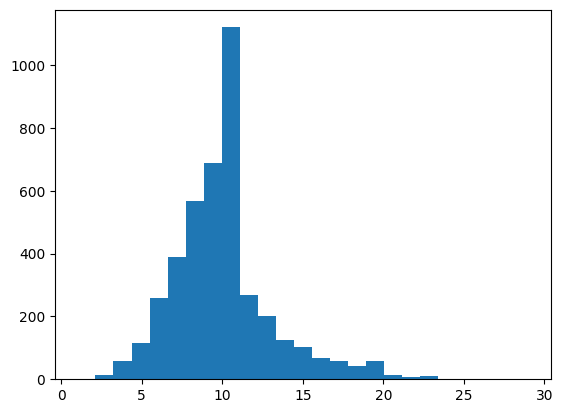

In [7]:
plt.hist(y.Rings, bins=25)

In [8]:
data = pd.concat([X, y], axis=1)
data

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


##Visualizations##

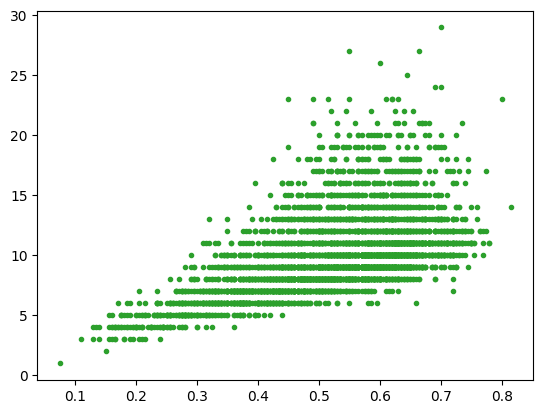

In [9]:
plt.plot(X.Length, y.Rings, "C2.", zorder=-3)

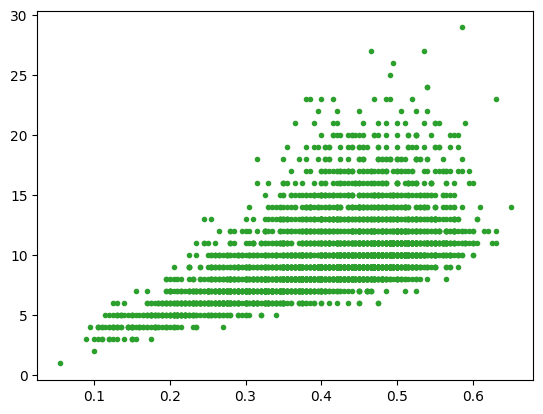

In [10]:
plt.plot(X.Diameter, y.Rings, "C2.", zorder=-3)

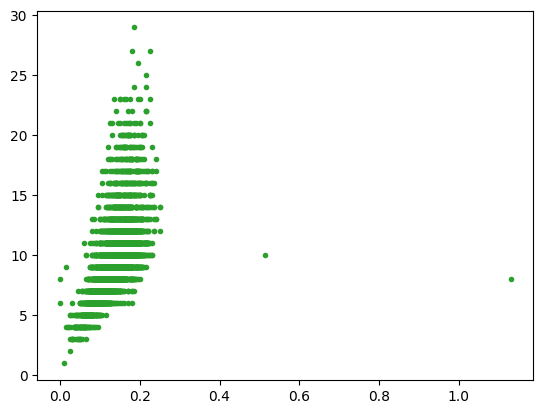

In [11]:
plt.plot(X.Height, y.Rings, "C2.", zorder=-3)

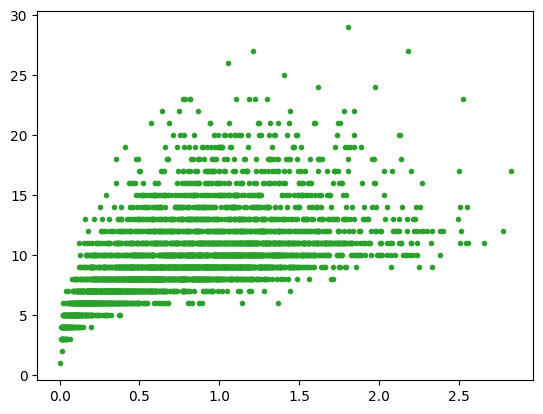

In [12]:
plt.plot(X.Whole_weight, y.Rings, "C2.", zorder=-3)

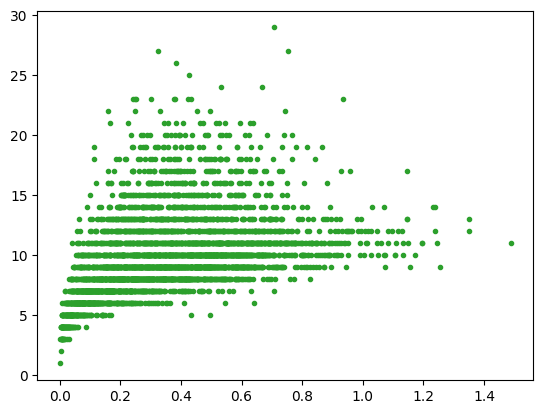

In [13]:
plt.plot(X.Shucked_weight, y.Rings, "C2.", zorder=-3)

##Overfitted GPS##

###Model 1 Diameter###

In [25]:
#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [26]:
Rings = data.Rings.values
Diameter = data.Diameter.values[:,None]

In [27]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(Diameter))
}

priors = {
    "hsgp(Diameter, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_diam = bmb.Model("Rings ~ 0 + hsgp(Diameter, m=10, c=1.5)", data, priors=priors)
idata_diam = model_diam.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


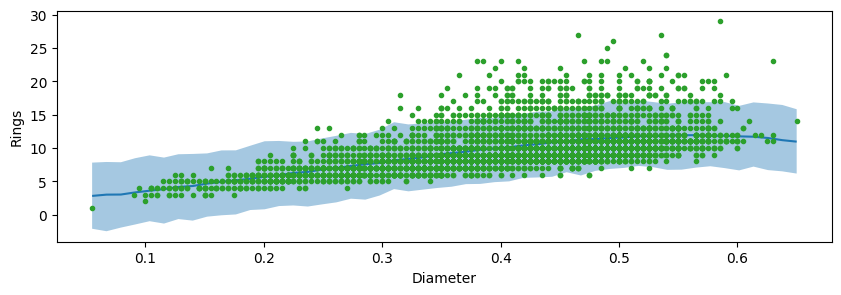

In [28]:
_, ax = bmb.interpret.plot_predictions(model_diam, idata_diam, ["Diameter"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(data.Diameter.values, data.Rings.values, "C2.")

###Model 2 Length and Weight###

In [ ]:
Length = data.Length.values[:,None]
Weight = data.Whole_weight.values[:,None]

In [ ]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(Diameter))
}

priors = {
    "hsgp(Length, m=10, c=1.5)": prior_gp,
    "hsgp(Weight, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_LenWei = bmb.Model("Rings ~ 0 + hsgp(Length, m=10, c=1.5) + hsgp(Weight, m=10, c=1.5)", data, priors=priors)
idata_LenWei = model_LenWei.fit()

In [ ]:
_, ax = bmb.interpret.plot_predictions(model_LenWei, idata_LenWei, ["Length"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})


In [ ]:
_, ax = bmb.interpret.plot_predictions(model_LenWei, idata_LenWei, ["Weight"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(data.Whole_weight.values, data.Rings.values, "C2.")

In [ ]:
plt.plot(X.Viscera_weight, y.Rings, "C2.", zorder=-3)

In [ ]:
plt.plot(X.Shell_weight, y.Rings, "C2.", zorder=-3)

##Model 1 WholeWeight^3, Length, Interaction##

In [41]:
model_pLenWeipro = bmb.Model("Rings ~ poly(Whole_weight, degree=3) + Length + Whole_weight:Length", data, family="negativebinomial")
idata_pLenWeipro = model_pLenWeipro.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


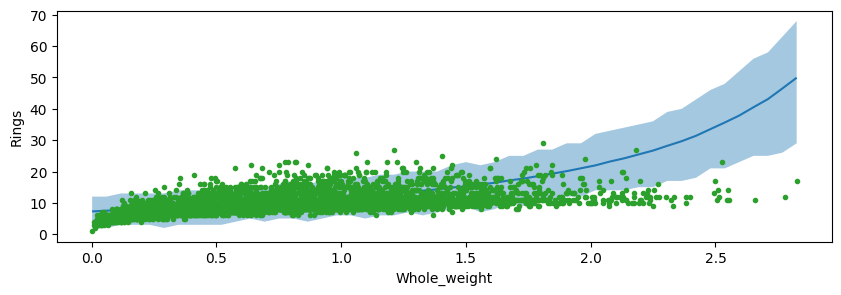

In [30]:
_, ax = bmb.interpret.plot_predictions(model_pLenWeipro, idata_pLenWeipro, "Whole_weight",
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(data.Whole_weight, data.Rings, "C2.")

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


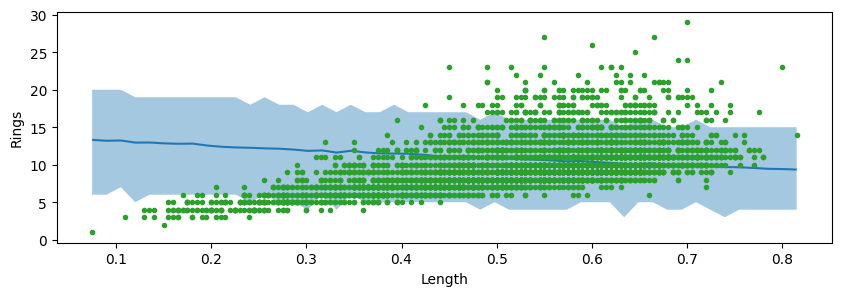

In [31]:
_, ax = bmb.interpret.plot_predictions(model_pLenWeipro, idata_pLenWeipro, "Length",
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(data.Length, data.Rings, "C2.")

##Model 2 WholeWeight^2, Length##

In [40]:
model_pLenWei2 = bmb.Model("Rings ~ poly(Whole_weight, degree=2) + Length", data, family="negativebinomial")
idata_pLenWei2 = model_pLenWei2.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


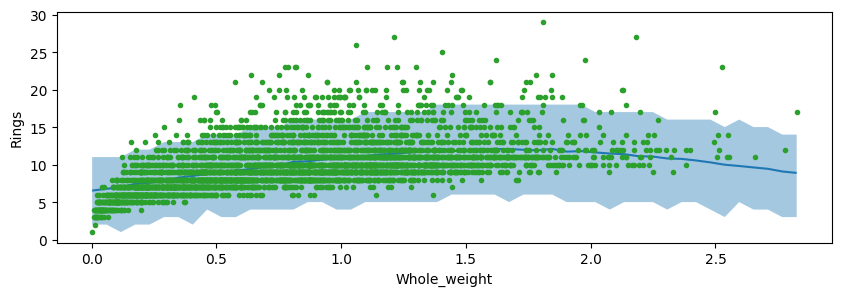

In [33]:
_, ax = bmb.interpret.plot_predictions(model_pLenWei2, idata_pLenWei2, "Whole_weight",
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(data.Whole_weight, data.Rings, "C2.")

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


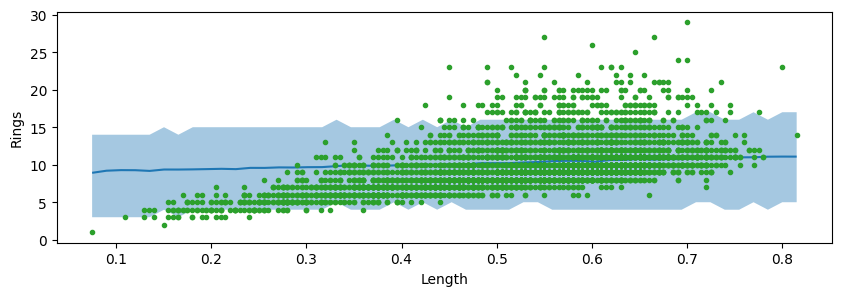

In [34]:
_, ax = bmb.interpret.plot_predictions(model_pLenWei2, idata_pLenWei2, "Length",
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(data.Length, data.Rings, "C2.")

##Model 3 WholeWeight^3,Len##

In [39]:
model_pLenWei3 = bmb.Model("Rings ~ poly(Whole_weight, degree=3) + Length", data, family="negativebinomial")
idata_pLenWei3 = model_pLenWei3.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


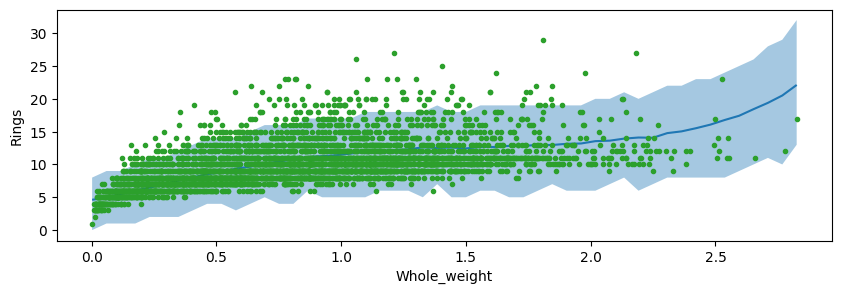

In [36]:
_, ax = bmb.interpret.plot_predictions(model_pLenWei3, idata_pLenWei3, "Whole_weight",
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(data.Whole_weight, data.Rings, "C2.")

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


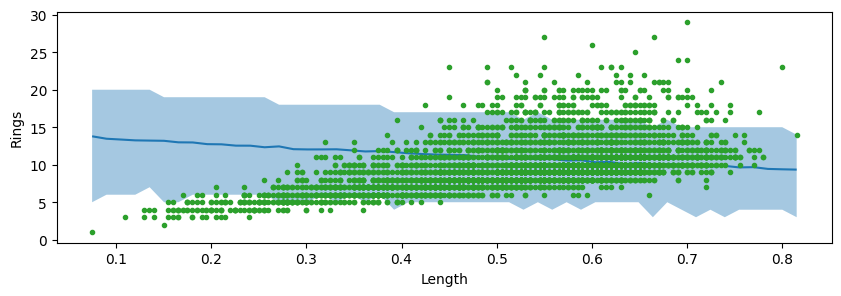

In [37]:
_, ax = bmb.interpret.plot_predictions(model_pLenWei3, idata_pLenWei3, "Length",
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(data.Length, data.Rings, "C2.")

##Analysis##

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

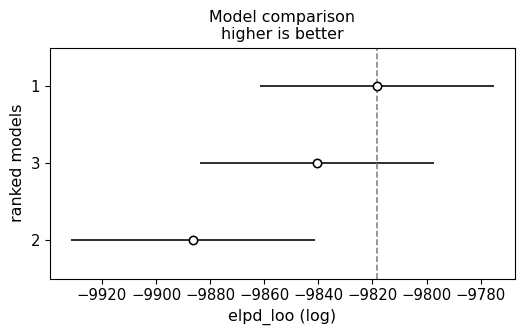

In [42]:
cmp_df_bmb = az.compare( {"1":idata_pLenWeipro,"2":idata_pLenWei2,"3":idata_pLenWei3} )
az.plot_compare(cmp_df_bmb)